# 1.1 Data Preparation

In [43]:
import numpy as np
from pandas import read_csv

def parse_csv(filepath: str):
    data = read_csv(filepath)

    # targets = array of target values (last column)
    targets = data.values[:, -1].astype(float)

    # inputs = array of input values (all columns except last)
    inputs = data.values[:, :-1].astype(float)

    return np.array(inputs), np.array(targets)

inputs, targets = parse_csv('glass-dataset.csv')

# 1.2 Classification

In [44]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [45]:
def pca(inputs):
    pca = PCA(n_components=2)
    
    return pca.fit_transform(inputs)

compressed = pca(inputs)

In [46]:
def knn(inputs, targets, k: int):
    classifier = KNeighborsClassifier(n_neighbors=k)
    
    classifier.fit(inputs, targets)
    
    return classifier.predict(inputs)

def find_optimal_k(inputs, targets, k: int):
    classifiedData = knn(inputs, targets, k)

    totalRight = 0
    totalEntries = len(targets)

    for i in range(totalEntries):
        if classifiedData[i] == targets[i]:
            totalRight += 1
    
    return totalRight / totalEntries

In [47]:
# Returns the most accurate k values' classified data
def classify_knn(inputs, targets) -> int:
    accuracies = []

    for k in range(1, 21):
        accuracies.append(find_optimal_k(inputs, targets, k))
    
    return knn(inputs, targets, accuracies.index(max(accuracies)) + 1)

classifiedData = classify_knn(compressed, targets)

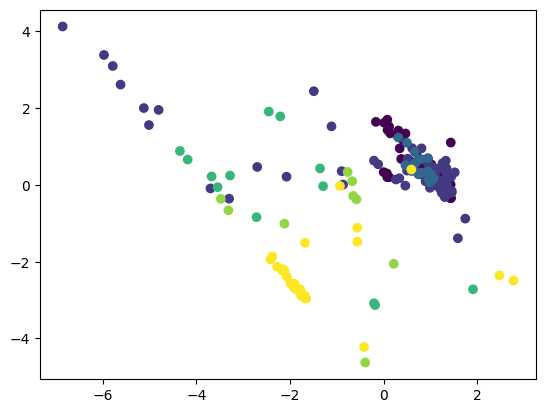

In [48]:
plt.figure()
plt.scatter(compressed[:, 0], compressed[:, 1], c=classifiedData)
plt.show()

In [ ]:
def classify_svm():
    